In [1]:
from google.colab import drive


In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_training-set.csv')

In [5]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from keras.utils import to_categorical
from keras.layers import Dense

In [7]:
label_encoder = LabelEncoder()
df['attack_cat_encoded'] = label_encoder.fit_transform(df['attack_cat'])
df = pd.get_dummies(df, columns=['proto', 'service', 'state'], drop_first=True)
df = df.drop(columns=['attack_cat', 'id'])

X = df.drop(columns=['label'])
y = df['attack_cat_encoded']
y_onehot = to_categorical(y)

In [8]:
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [9]:
feature_importances = model.feature_importances_
features_ranked = sorted(list(zip(X.columns, feature_importances)), key=lambda x: x[1], reverse=True)

print(features_ranked[:20])

[('service_dns', 0.7140337), ('attack_cat_encoded', 0.20601222), ('smean', 0.046286944), ('sttl', 0.032070447), ('dur', 0.0011605837), ('state_INT', 0.00016537105), ('rate', 7.174198e-05), ('sbytes', 6.4222e-05), ('ct_dst_sport_ltm', 3.3021686e-05), ('sloss', 1.5997563e-05), ('tcprtt', 1.3907831e-05), ('ct_srv_src', 1.0755306e-05), ('ct_src_dport_ltm', 1.016062e-05), ('sjit', 9.450075e-06), ('ct_dst_src_ltm', 6.980171e-06), ('synack', 5.404572e-06), ('dbytes', 5.3926456e-06), ('sload', 5.255364e-06), ('ct_srv_dst', 3.4756263e-06), ('dmean', 3.3087645e-06)]


In [10]:
selected_features = [feature[0] for feature in features_ranked[:20]]
X_selected = X[selected_features]

In [11]:
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)
X_selected_reshaped = X_selected_scaled.reshape(X_selected_scaled.shape[0], X_selected_scaled.shape[1], 1)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_selected_reshaped, y_onehot, test_size=0.2, random_state=42)

In [13]:
from keras.layers import Input
from keras.models import Model

In [14]:
encoding_dim = 50
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_val, X_val))

encoder = Model(input_layer, encoded)
num_classes = y_onehot.shape[1]
classification_layer = Dense(num_classes, activation='sigmoid')(encoder.output)

final_model = Model(inputs=encoder.input, outputs=classification_layer)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
final_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2059/2059 [==============================] - 7s 3ms/step - loss: 0.6770 - val_loss: 0.6537
Epoch 2/10
2059/2059 [==============================] - 4s 2ms/step - loss: 0.6393 - val_loss: 0.6509
Epoch 3/10
2059/2059 [==============================] - 6s 3ms/step - loss: 0.6378 - val_loss: 0.6500
Epoch 4/10
2059/2059 [==============================] - 5s 2ms/step - loss: 0.6371 - val_loss: 0.6495
Epoch 5/10
2059/2059 [==============================] - 4s 2ms/step - loss: 0.6368 - val_loss: 0.6493
Epoch 6/10
2059/2059 [==============================] - 6s 3ms/step - loss: 0.6367 - val_loss: 0.6493
Epoch 7/10
2059/2059 [==============================] - 4s 2ms/step - loss: 0.6366 - val_loss: 0.6492
Epoch 8/10
2059/2059 [==============================] - 5s 2ms/step - loss: 0.6366 - val_loss: 0.6491
Epoch 9/10
2059/2059 [==============================] - 7s 3ms/step - loss: 0.6365 - val_loss: 0.6491
Epoch 10/10
2059/2059 [==============================] - 4s 2ms/step - loss: 0.636

In [15]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(y_onehot.shape[1], activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2059/2059 [==============================] - 32s 14ms/step - loss: 0.1317 - accuracy: 0.7630 - val_loss: 0.0732 - val_accuracy: 0.8661
Epoch 2/10
2059/2059 [==============================] - 30s 15ms/step - loss: 0.0345 - accuracy: 0.9495 - val_loss: 0.0233 - val_accuracy: 0.9775
Epoch 3/10
2059/2059 [==============================] - 31s 15ms/step - loss: 0.0317 - accuracy: 0.9515 - val_loss: 0.0606 - val_accuracy: 0.8949
Epoch 4/10
2059/2059 [==============================] - 29s 14ms/step - loss: 0.0280 - accuracy: 0.9590 - val_loss: 0.0175 - val_accuracy: 0.9768
Epoch 5/10
2059/2059 [==============================] - 30s 15ms/step - loss: 0.0179 - accuracy: 0.9778 - val_loss: 0.0091 - val_accuracy: 0.9860
Epoch 6/10
2059/2059 [==============================] - 30s 15ms/step - loss: 0.0389 - accuracy: 0.9294 - val_loss: 0.0633 - val_accuracy: 0.8644
Epoch 7/10
2059/2059 [==============================] - 30s 14ms/step - loss: 0.0268 - accuracy: 0.9578 - val_loss: 0.0095 -

In [16]:
gru_model = Sequential()
gru_model.add(GRU(50, input_shape=(X_train.shape[1], 1)))
gru_model.add(Dense(y_onehot.shape[1], activation='sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2059/2059 [==============================] - 35s 15ms/step - loss: 0.1079 - accuracy: 0.8019 - val_loss: 0.0421 - val_accuracy: 0.9224
Epoch 2/10
2059/2059 [==============================] - 31s 15ms/step - loss: 0.0444 - accuracy: 0.9124 - val_loss: 0.0337 - val_accuracy: 0.9283
Epoch 3/10
2059/2059 [==============================] - 30s 15ms/step - loss: 0.0325 - accuracy: 0.9321 - val_loss: 0.0244 - val_accuracy: 0.9668
Epoch 4/10
2059/2059 [==============================] - 33s 16ms/step - loss: 0.0267 - accuracy: 0.9492 - val_loss: 0.0446 - val_accuracy: 0.9145
Epoch 5/10
2059/2059 [==============================] - 31s 15ms/step - loss: 0.0318 - accuracy: 0.9469 - val_loss: 0.0354 - val_accuracy: 0.9449
Epoch 6/10
2059/2059 [==============================] - 31s 15ms/step - loss: 0.0197 - accuracy: 0.9700 - val_loss: 0.0104 - val_accuracy: 0.9823
Epoch 7/10
2059/2059 [==============================] - 30s 15ms/step - loss: 0.0159 - accuracy: 0.9762 - val_loss: 0.0061 -

In [17]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dense(y_onehot.shape[1], activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2059/2059 [==============================] - 16s 7ms/step - loss: 0.0605 - accuracy: 0.9074 - val_loss: 0.0117 - val_accuracy: 0.9783
Epoch 2/10
2059/2059 [==============================] - 14s 7ms/step - loss: 0.0075 - accuracy: 0.9897 - val_loss: 0.0040 - val_accuracy: 0.9976
Epoch 3/10
2059/2059 [==============================] - 14s 7ms/step - loss: 0.0048 - accuracy: 0.9937 - val_loss: 0.0024 - val_accuracy: 0.9987
Epoch 4/10
2059/2059 [==============================] - 14s 7ms/step - loss: 0.0035 - accuracy: 0.9961 - val_loss: 0.0136 - val_accuracy: 0.9818
Epoch 5/10
2059/2059 [==============================] - 14s 7ms/step - loss: 0.0083 - accuracy: 0.9957 - val_loss: 0.0034 - val_accuracy: 0.9971
Epoch 6/10
2059/2059 [==============================] - 14s 7ms/step - loss: 0.0024 - accuracy: 0.9978 - val_loss: 0.0019 - val_accuracy: 0.9981
Epoch 7/10
2059/2059 [==============================] - 14s 7ms/step - loss: 0.0016 - accuracy: 0.9985 - val_loss: 0.0012 - val_ac

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [19]:
def evaluate_model(model, X, y_true, model_name):
    # Get model predictions
    y_pred_probs = model.predict(X)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true_labels = y_true.argmax(axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true_labels, y_pred)
    precision = precision_score(y_true_labels, y_pred, average='macro')
    recall = recall_score(y_true_labels, y_pred, average='macro')
    f1 = f1_score(y_true_labels, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true_labels, y_pred)

    # Display metrics
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("="*60)

In [20]:
models = [final_model, lstm_model, gru_model, rnn_model]  # Replace with your model instances
model_names = ["Autoencoder-based Classifier", "LSTM", "GRU", "RNN"]

for model, name in zip(models, model_names):
    evaluate_model(model, X_val, y_val, name)

515/515 [==============================] - 1s 1ms/step
Performance Metrics for Autoencoder-based Classifier:
Accuracy: 0.9985
Precision: 0.9931
Recall: 0.9365
F1-Score: 0.9532
Confusion Matrix:
[[ 131    0    0    0    0    0    0    0    0    0]
 [   0  111    6    0    0    0    0    0    0    0]
 [   0    0  786    0    0    0    0    0    0    0]
 [   0    0    8 2267    0    0    0    0    0    0]
 [   0    0    0    0 1212    0    0    0    0    0]
 [   0    0    0    0    0 3722    1    0    0    0]
 [   0    0    0    0    0    0 7418    0    0    0]
 [   0    0    0    0    0    0    6  717    0    0]
 [   0    0    0    0    0    0    0    0   75    0]
 [   0    0    0    0    0    0    0    0    4    3]]
515/515 [==============================] - 3s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance Metrics for LSTM:
Accuracy: 0.9969
Precision: 0.8775
Recall: 0.8895
F1-Score: 0.8829
Confusion Matrix:
[[ 122    9    0    0    0    0    0    0    0    0]
 [   0  116    1    0    0    0    0    0    0    0]
 [   1    2  781    2    0    0    0    0    0    0]
 [   0    0   15 2257    0    1    2    0    0    0]
 [   0    0    0    0 1209    1    0    0    2    0]
 [   0    0    0    0    0 3723    0    0    0    0]
 [   0    0    0    0    0    0 7418    0    0    0]
 [   0    0    0    0    0    3    5  715    0    0]
 [   0    0    0    0    0    0    0    0   75    0]
 [   0    0    0    0    0    0    0    0    7    0]]
515/515 [==============================] - 3s 4ms/step
Performance Metrics for GRU:
Accuracy: 0.9984
Precision: 0.9369
Recall: 0.9257
F1-Score: 0.9280
Confusion Matrix:
[[ 131    0    0    0    0    0    0    0    0    0]
 [   0  115    2    0    0    0    0    0    0    0]
 [   0    0  786    0    0    0    0    0    0    0]
 [   0    0    6 2267    0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
df_test = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_testing-set.csv')

In [22]:
df_test['attack_cat_encoded'] = label_encoder.transform(df_test['attack_cat'])
df_test = pd.get_dummies(df_test, columns=['proto', 'service', 'state'], drop_first=True)
df_test = df_test.drop(columns=['attack_cat', 'id'])

In [23]:
X_test_data = df_test.drop(columns=['label'])
y_test_data = df_test['attack_cat_encoded']
y_test_data_onehot = to_categorical(y_test_data)

In [24]:
selected_features = [feature[0] for feature in features_ranked[:20]]

In [25]:
X_test_data_selected = X_test_data[selected_features]

In [26]:
X_test_data_selected_scaled = scaler.transform(X_test_data_selected)
X_test_data_selected_reshaped = X_test_data_selected_scaled.reshape(X_test_data_selected_scaled.shape[0], X_test_data_selected_scaled.shape[1], 1)

In [27]:
evaluation_results_selected = []

In [28]:
for model, name in zip(models, model_names):
    # Get model predictions
    y_pred_probs = model.predict(X_test_data_selected_reshaped)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true_labels = y_test_data_onehot.argmax(axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true_labels, y_pred)
    precision = precision_score(y_true_labels, y_pred, average='macro')
    recall = recall_score(y_true_labels, y_pred, average='macro')
    f1 = f1_score(y_true_labels, y_pred, average='macro')

    evaluation_results_selected.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

evaluation_df_selected = pd.DataFrame(evaluation_results_selected)

evaluation_df_selected

   1/5480 [..............................] - ETA: 2:33

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5480/5480 [==============================] - 16s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1-Score
0,Autoencoder-based Classifier,0.993498,0.982004,0.892613,0.912168
1,LSTM,0.991822,0.858479,0.867488,0.859997
2,GRU,0.995033,0.936995,0.907008,0.909189
3,RNN,0.994109,0.865983,0.886299,0.875217


5480/5480 [==============================] - 25s 4ms/step


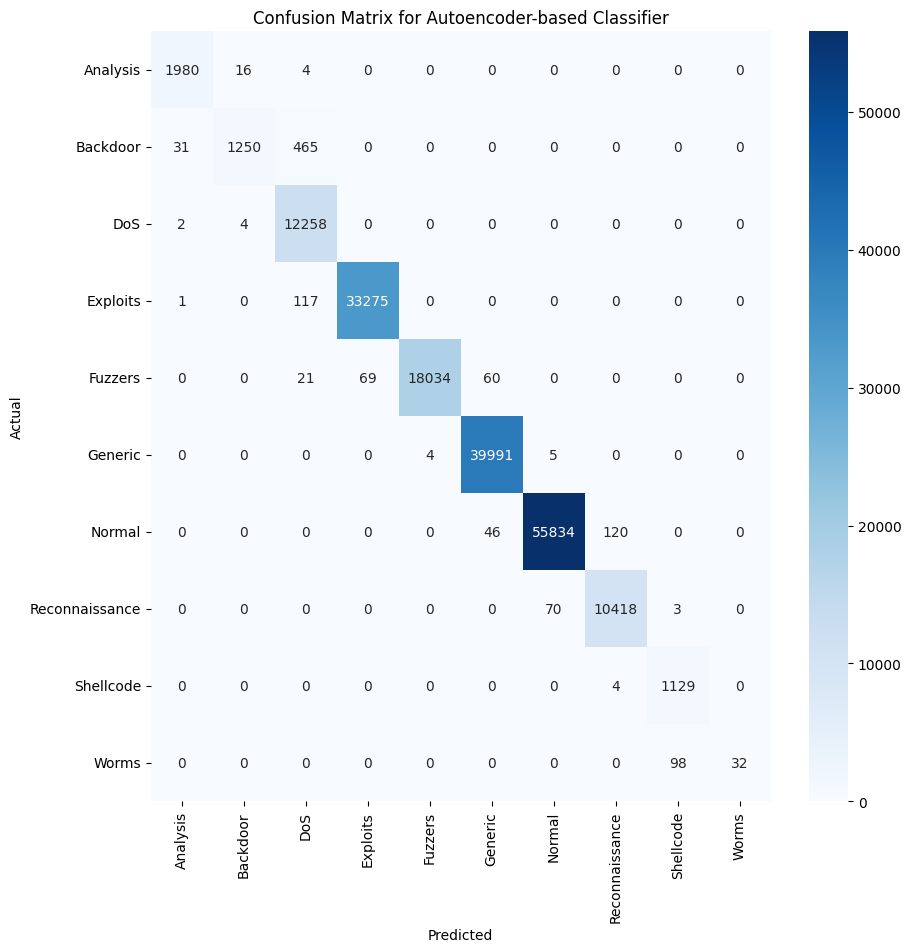

5480/5480 [==============================] - 24s 4ms/step


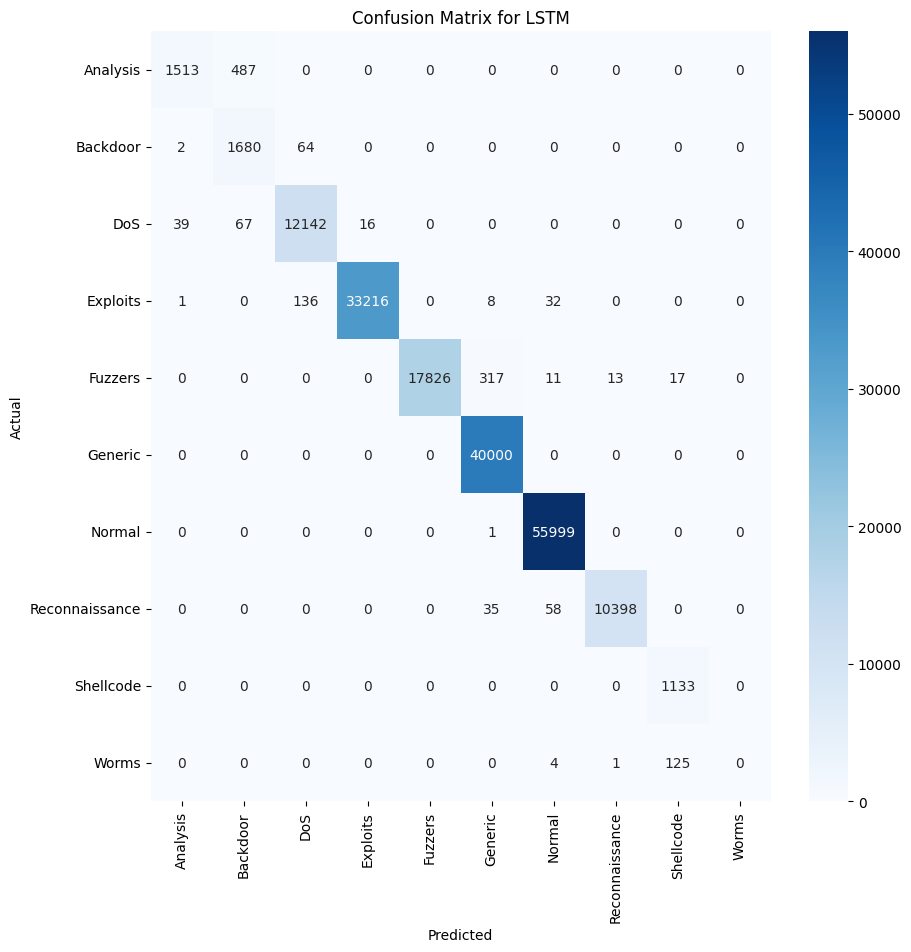

5480/5480 [==============================] - 23s 4ms/step


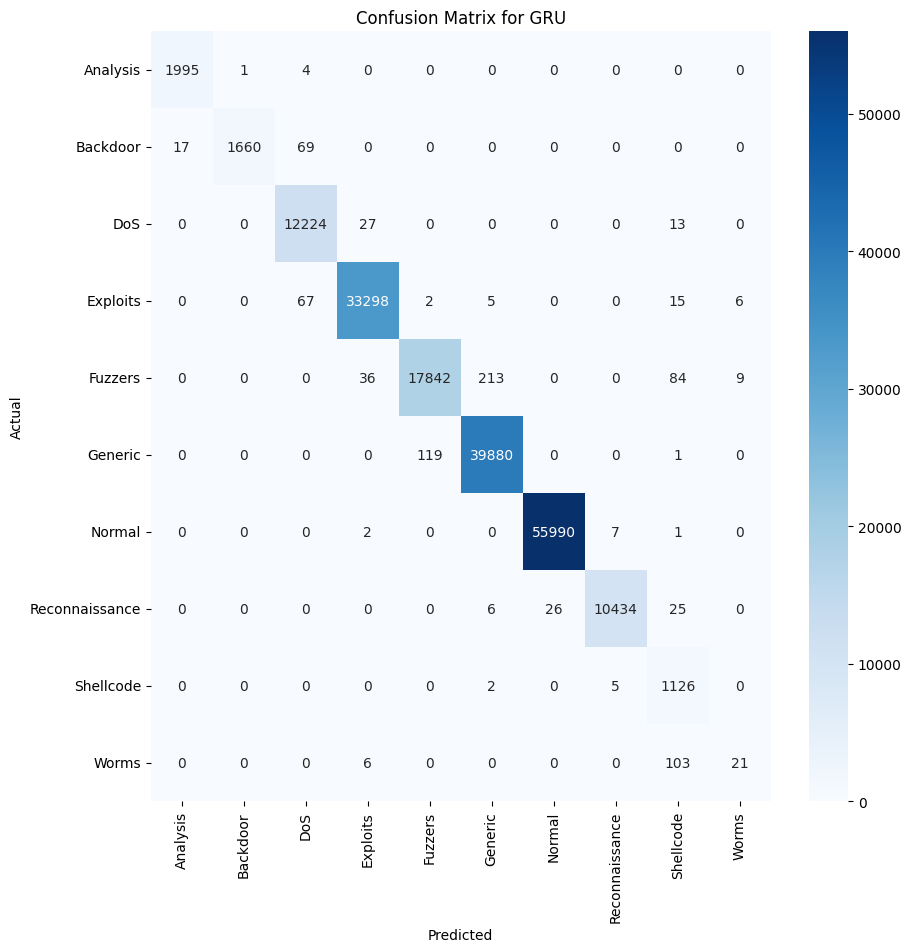

5480/5480 [==============================] - 19s 3ms/step


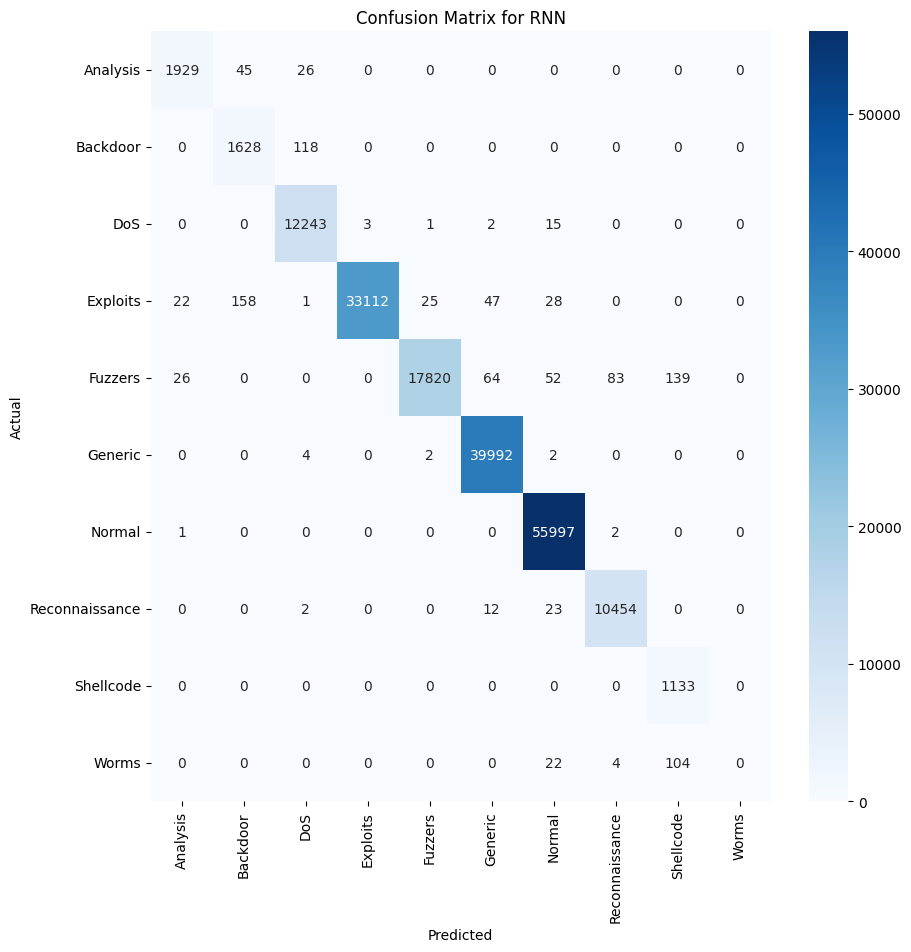

In [29]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, model_name, classes):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes,
                yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Assuming the label encoder's classes are the labels for the attack types
attack_labels = label_encoder.classes_

for model, name in zip(models, model_names):
    y_pred_probs = model.predict(X_test_data_selected_reshaped)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true_labels = y_test_data_onehot.argmax(axis=1)
    plot_confusion_matrix(y_true_labels, y_pred, name, attack_labels)

5480/5480 [==============================] - 12s 2ms/step


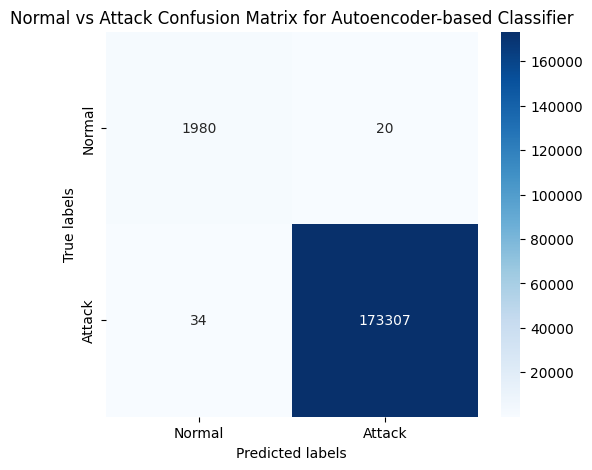

5480/5480 [==============================] - 25s 5ms/step


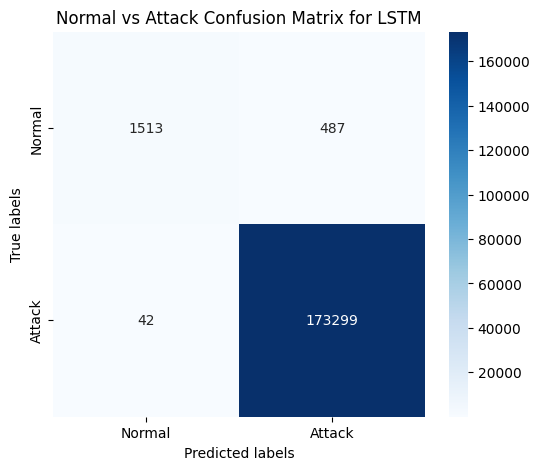

5480/5480 [==============================] - 24s 4ms/step


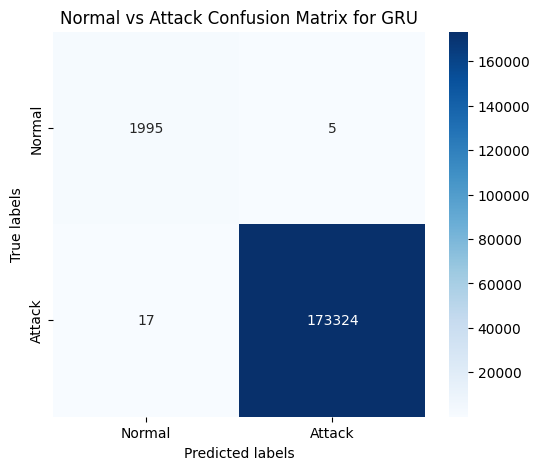

5480/5480 [==============================] - 19s 4ms/step


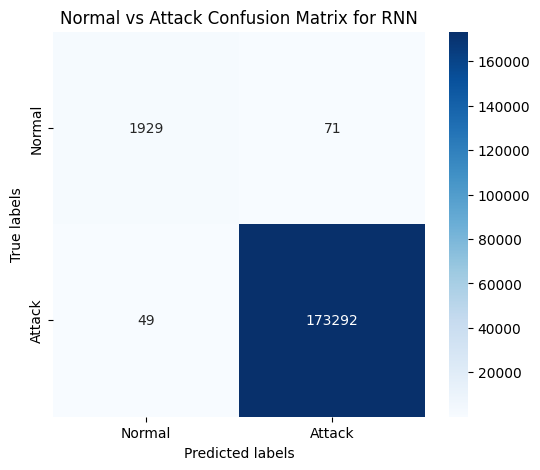

In [32]:
def plot_normal_attack_confusion_matrix(y_true, y_pred, model_name):
    # Convert multi-class labels into binary: 0 for 'normal' and 1 for 'attack'
    y_true_binary = (y_true != 0).astype(int)  # Assuming 0 represents the 'normal' class
    y_pred_binary = (y_pred != 0).astype(int)

    # Generate binary confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Normal vs Attack Confusion Matrix for {model_name}')
    plt.show()

for model, name in zip(models, model_names):
    y_pred_probs = model.predict(X_test_data_selected_reshaped)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true_labels = y_test_data_onehot.argmax(axis=1)

    plot_normal_attack_confusion_matrix(y_true_labels, y_pred, name)